In [48]:
# загружаем библиотеки
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')
import requests
from urllib.parse import urlencode

### Подготовка данных

In [49]:
#df=pd.read_csv('hw_bootstrap.csv',sep=';')
#df.head()

In [50]:
# загружаем данные
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# ссылка на данные
public_key = 'https://disk.yandex.ru/d/FPMcY4_9kTUpNg'                
# имя файла
file_names = 'hw_bootstrap.csv'                          

datasets = 'df'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
    
# загружаем данные по ссылкам
globals()[datasets] = pd.read_csv(download_url,sep=';')

In [51]:
df = df.drop(columns=df.columns[0])
df.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [52]:
df.dtypes

value                object
experimentVariant    object
dtype: object

In [53]:
df['value'] = df['value'].str.replace(',', '.').astype('float')
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [54]:
# функция для бутстрепа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### Разбиение данных на контрольную и тестовую группу

In [55]:
df_control = df.query('experimentVariant == "Control"').reset_index(drop=True)['value']
df_control

0      10.380495
1       9.546867
2      11.088215
3      10.147274
4       9.789808
         ...    
495    10.973929
496    10.261074
497     8.780090
498    11.169078
499    11.499566
Name: value, Length: 500, dtype: float64

In [56]:
df_test = df.query('experimentVariant == "Treatment"').reset_index(drop=True)['value']
df_test.head()

0    10.380495
1     9.546867
2    11.088215
3    10.147274
4     9.789808
Name: value, dtype: float64

#### Распределения контрольной и тестовой группы

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


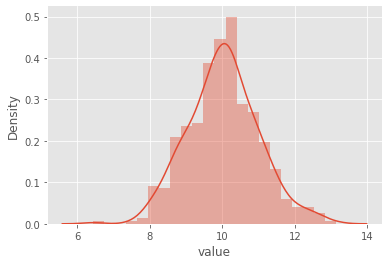

In [57]:
# Контрольная группа
sns.distplot(df_control)
sns.despine()

Распределение нормальное

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


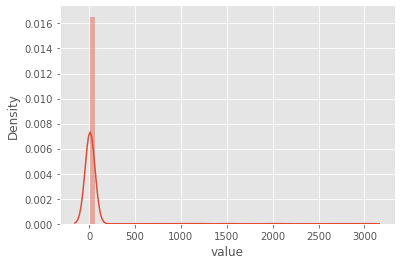

In [58]:
# Тестовая группа
sns.distplot(df_test)
sns.despine()

Распределение ненормальное - выбросы

### bootstrap (np.mean)
* H0: Средние значения в двух группах не различаются
* H1: Средние значения различаются

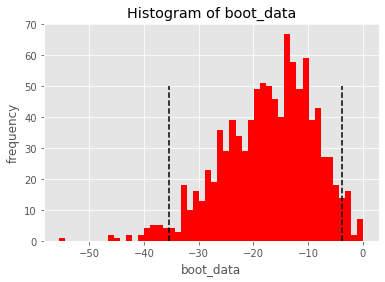

In [59]:
booted_data_means = get_bootstrap(
                        df_control, 
                        df_test, 
                        boot_it = 1000, 
                        statistic = np.mean)

In [60]:
booted_data_means["p_value"]

0.03994002946751298

In [61]:
booted_data_means["quants"]

,0
0.025,-35.510587
0.975,-3.850691


Средние значения в тестовой и контрольной группах различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал не попадает нулевое значение разницы между двумя средними.

p-value < 0.05 говорит о том, что при условии верности нулевой гипотезы о равенстве средних в двух группах вероятность получить такое или еще большее отклонение разницы между средними значениями бутстрап-выборок от 0 составляет менее 5%. Значит, мы имеем основание отвергнуть нулевую гипотезу в пользу альтернативной.

### bootstrap (np.median)
* H0: Медианы в двух группах не различаются
* H1: Медианы различаются

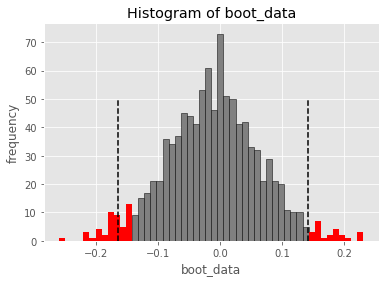

In [62]:
booted_data_medians = get_bootstrap(
                          df_control, 
                          df_test, 
                          boot_it = 1000, 
                          statistic = np.median)

In [63]:
booted_data_medians["p_value"]

0.877897555102167

In [64]:
booted_data_medians["quants"]

,0
0.025,-0.165059
0.975,0.142406


Медианы в тестовой и контрольной группах не различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал попадает нулевое значение разницы между медианами двух групп.

p-value > 0.05 говорит о том, что при условии верности нулевой гипотезы о равенстве медиан в двух группах вероятность получить такое или еще большее отклонение разницы между медианами бутстрап-выборок от 0 составляет более 5%. Значит, мы не имеем весомых оснований отвергнуть нулевую гипотезу.

### U-тест Mann-Whitney
* H0: Группы не различаются
* H1: Группы различаются

In [65]:
mannwhitneyu(df_control, df_test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Значение p-value > 0.05 говорит об отсутствии статистически значимых различий между контрольной и тестовой группами (значение U-критерия больше, чем пороговое). Мы не имеем оснований отвергнуть нулевую гипотезу, то есть группы не отличаются.

### T-test
* H0: В генеральной совокупности никакого различия между средними значениями нет
* H1: Средние в генеральной совокупности не равны

In [66]:
stats.ttest_ind(df_control, df_test)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

Значение p-value < 0.05 говорит о том, что мы имеем основание отвергнуть нулевую гипотезу, то есть средние в группах значимо различаются.

### Выводы

1. Бутстрап для средних значений показал статистически значимое различие `(p < 0.05)` между средними двух групп. Можем отвергнуть нулевую гипотезу.
2. Бутстрап для медиан показал `отсутствие статистически значимого различия (p > 0.05)` между медианами двух групп, что могло привести к принятию нулевой гипотезы. Также отметим, что медиана гораздо менее чувствительна к выбросам, чем среднее.
3. Непараметрический U-критерий Манна-Уитни также менее чувствителен к выбросам, поскольку использует ранговую шкалу для оценки различий между двумя группами. Данный критерий также показал, что между группами `нет статистически значимых различий (p > 0.05)`, следовательно, можем принять нулевую гипотезу.
4. T-тест показал различие средних в группах`(p < 0.05)`, из-за чего может быть отвергнута нулевая гипотеза.

Таким образом, в рассмотренном случае стоит доверять бутстрапу для `медиан` и `U-критерию Манна-Уитни`, поскольку они менее чувствительны к экстремально большим (или малым) значениям (по графику распределения в тестовой группе было отмечено наличие выбросов). На основе выбранных тестов для данного случаи можем принять нулевую гипотезу и сделать вывод, что статистически значимых различий между тестовой и контрольной групп нет.